# EDA of data used for LSTM/RNN/GRU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import csv
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import os
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# sess = tf.Session(config=config)

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.preprocessing import MinMaxScaler
os.environ['CUDA_VISIBLE_DEVICES']=''
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [2]:

# def get_load_data(date):
#     url = 'http://www.delhisldc.org/Loaddata.aspx?mode='
#     print('Scraping ' + date, end=' ')
#     resp = requests.get(url + date) # send a get request to the url, get response
#     soup = BeautifulSoup(resp.text, 'lxml') # Yummy HTML soup
#     table = soup.find('table', {'id':'ContentPlaceHolder3_DGGridAv'}) # get the table from html
#     trs = table.findAll('tr') # extract all rows of the table
#     if len(trs[1:])==288: # no need to create csv file, if there's no data
#         with open('lstm_data.csv', 'a') as f:  #'a' makes sure the values are appended at the end of the already existing file
#             writer = csv.writer(f)
#             for tr in trs[1:]:
#                 time, delhi = tr.findChildren('font')[:2]
#                 writer.writerow([date + ' ' + time.text, delhi.text])
#     if len(trs[1:]) != 288:
#         print('Some of the load values are missing..')
#     else:
#         print('Done')

In [3]:

# for i in range(62, 0, -1):
#     yesterday = datetime.today() - timedelta(i)
#     yesterday = yesterday.strftime('%d/%m/%Y')
#     get_load_data(yesterday)    

In [4]:
# for i in range(31, 0, -1):
#     yesterday = datetime.today() - timedelta(i)
#     yesterday = yesterday.strftime('%d/%m/%Y')
#     try:
#         print(data[yesterday].shape[0])
#     except:
#         print(yesterday, 'not found')
     

In [2]:
data = pd.read_csv('lstm_data.csv', header=None, names=['datetime', 'load'], index_col=[0], parse_dates=[0], infer_datetime_format=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17280 entries, 2018-09-25 00:00:00 to 2018-11-24 23:55:00
Data columns (total 1 columns):
load    17280 non-null float64
dtypes: float64(1)
memory usage: 270.0 KB


In [4]:
data.shape

(17280, 1)

In [5]:
data.shape[0] / 288 

60.0

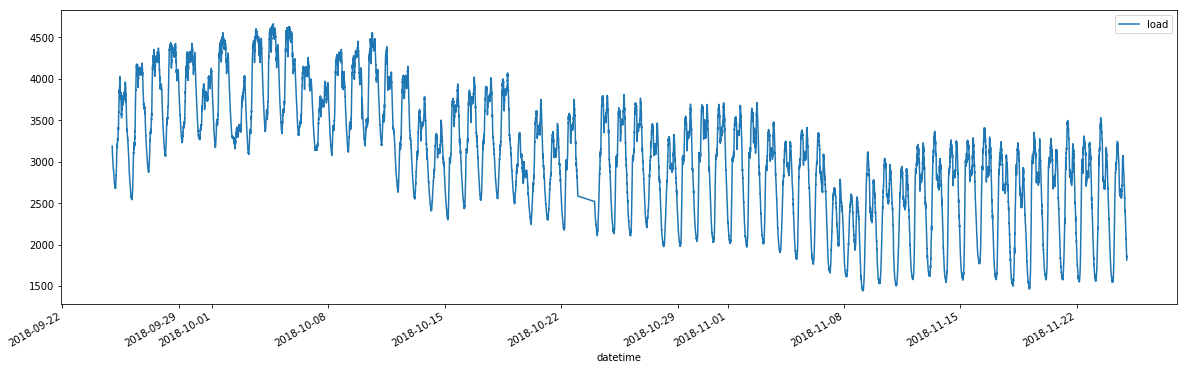

In [8]:
# data['27/10/2018'].plot()
data.plot()

plt.show()

# Version 2

Use last `nlags` days values at time t to predict the load of today's time t load

In [9]:
data.head(3)

,load
datetime,
2018-09-25 00:00:00,3189.83
2018-09-25 00:05:00,3159.06
2018-09-25 00:10:00,3149.09


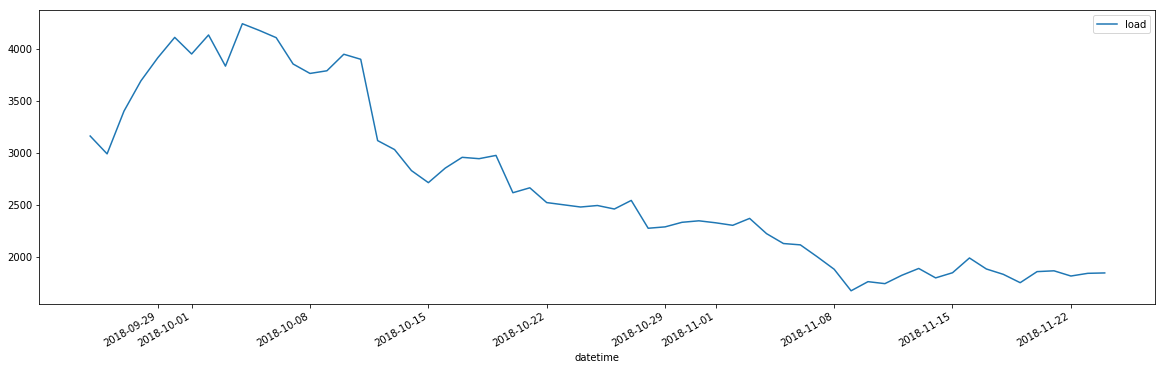

In [10]:
data.at_time('00:05:00').plot()

In [23]:
df = pd.DataFrame(columns=['time'] + list(map(str, range(int(data.shape[0] / 288)))))

In [24]:
for idx, time in enumerate(sorted(set(data.index.time))):
    df.loc[idx] = [time.strftime(format='%H:%M:%S')] + list(data.at_time(time)['load'].values)
#     data.at_time(time).plot()
#     if idx>10: break


In [25]:
df.head()

,time,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,00:00:00,3189.83,3017.99,3426.82,3742.89,3942.27,4120.84,3956.89,4165.08,3865.92,...,1837.89,2016.32,1899.06,1807.17,1763.10,1864.32,1869.17,1861.12,1859.78,1857.90
1,00:05:00,3159.06,2987.53,3398.53,3688.82,3911.38,4106.86,3947.32,4130.10,3830.75,...,1845.33,1987.13,1881.36,1830.02,1749.68,1856.01,1863.78,1813.69,1839.65,1843.34
2,00:10:00,3149.09,2957.38,3376.95,3679.72,3923.22,4074.21,3914.40,4087.99,3813.56,...,1826.49,1995.60,1863.87,1811.94,1744.79,1830.61,1828.91,1815.72,1828.55,1838.49
3,00:15:00,3147.14,2937.59,3356.01,3664.89,3877.00,4059.90,3898.49,4078.04,3787.39,...,1808.62,1983.07,1851.78,1752.79,1731.72,1820.61,1841.75,1804.82,1823.34,1801.54
4,00:20:00,3099.95,2931.60,3345.17,3638.68,3833.22,4022.66,3879.98,4055.72,3782.19,...,1795.87,1967.24,1829.15,1750.78,1712.27,1819.67,1817.94,1795.77,1843.38,1785.53


In [26]:
df.index = df['time']
df = df.drop('time', 1)

In [27]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,3189.83,3017.99,3426.82,3742.89,3942.27,4120.84,3956.89,4165.08,3865.92,4277.75,...,1837.89,2016.32,1899.06,1807.17,1763.10,1864.32,1869.17,1861.12,1859.78,1857.90
00:05:00,3159.06,2987.53,3398.53,3688.82,3911.38,4106.86,3947.32,4130.10,3830.75,4238.09,...,1845.33,1987.13,1881.36,1830.02,1749.68,1856.01,1863.78,1813.69,1839.65,1843.34
00:10:00,3149.09,2957.38,3376.95,3679.72,3923.22,4074.21,3914.40,4087.99,3813.56,4213.07,...,1826.49,1995.60,1863.87,1811.94,1744.79,1830.61,1828.91,1815.72,1828.55,1838.49
00:15:00,3147.14,2937.59,3356.01,3664.89,3877.00,4059.90,3898.49,4078.04,3787.39,4211.58,...,1808.62,1983.07,1851.78,1752.79,1731.72,1820.61,1841.75,1804.82,1823.34,1801.54
00:20:00,3099.95,2931.60,3345.17,3638.68,3833.22,4022.66,3879.98,4055.72,3782.19,4186.13,...,1795.87,1967.24,1829.15,1750.78,1712.27,1819.67,1817.94,1795.77,1843.38,1785.53


In [28]:
df.loc['00:00:00']

0     3189.83
1     3017.99
2     3426.82
3     3742.89
4     3942.27
5     4120.84
6     3956.89
7     4165.08
8     3865.92
9     4277.75
10    4211.49
11    4112.25
12    3863.71
13    3812.23
14    3810.25
15    3955.70
16    3921.21
17    3133.71
18    3059.76
19    2839.81
20    2742.01
21    2884.78
22    2996.43
23    2964.35
24    3010.54
25    2648.30
26    2700.90
27    2562.34
28    2520.40
29    2491.14
30    2487.83
31    2567.64
32    2286.14
33    2313.41
34    2354.25
35    2368.88
36    2335.87
37    2319.43
38    2380.31
39    2283.87
40    2165.11
41    2140.82
42    2016.19
43    1880.24
44    1673.24
45    1781.98
46    1770.85
47    1838.00
48    1905.57
49    1794.49
50    1837.89
51    2016.32
52    1899.06
53    1807.17
54    1763.10
55    1864.32
56    1869.17
57    1861.12
58    1859.78
59    1857.90
Name: 00:00:00, dtype: float64

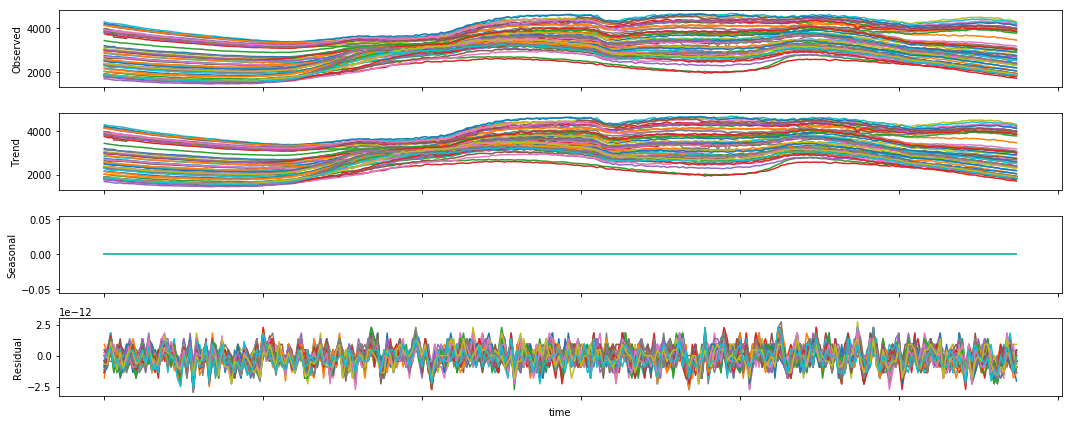

In [29]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 1 #daily freq

result = seasonal_decompose(df, freq=decompfreq, model='aditive')

result.plot()
plt.show()

Only trend is present not seasonality, let's remove it by differencing

In [30]:
dt_df = df.diff(1, axis=1)

In [31]:
dt_df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,NaN,-171.84,408.83,316.07,199.38,178.57,-163.95,208.19,-299.16,411.83,...,43.40,178.43,-117.26,-91.89,-44.07,101.22,4.85,-8.05,-1.34,-1.88
00:05:00,NaN,-171.53,411.00,290.29,222.56,195.48,-159.54,182.78,-299.35,407.34,...,49.55,141.80,-105.77,-51.34,-80.34,106.33,7.77,-50.09,25.96,3.69
00:10:00,NaN,-191.71,419.57,302.77,243.50,150.99,-159.81,173.59,-274.43,399.51,...,69.56,169.11,-131.73,-51.93,-67.15,85.82,-1.70,-13.19,12.83,9.94
00:15:00,NaN,-209.55,418.42,308.88,212.11,182.90,-161.41,179.55,-290.65,424.19,...,39.58,174.45,-131.29,-98.99,-21.07,88.89,21.14,-36.93,18.52,-21.80
00:20:00,NaN,-168.35,413.57,293.51,194.54,189.44,-142.68,175.74,-273.53,403.94,...,26.97,171.37,-138.09,-78.37,-38.51,107.40,-1.73,-22.17,47.61,-57.85


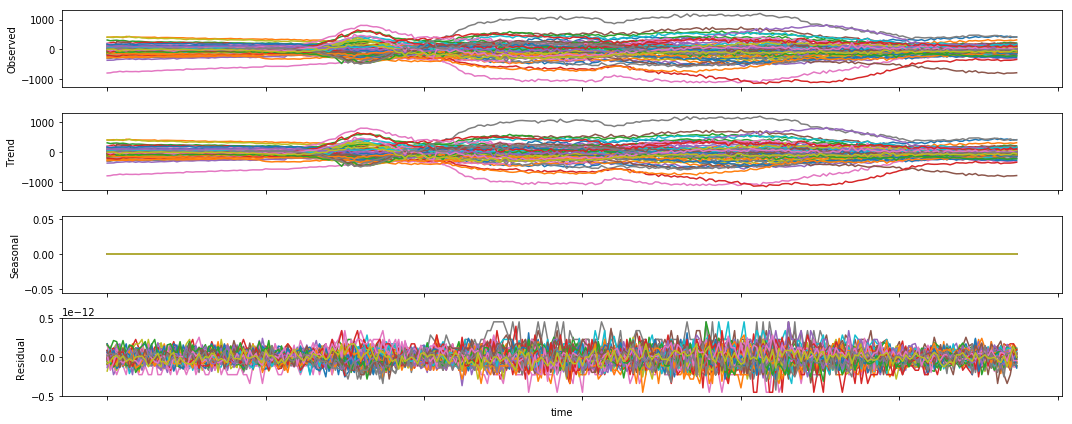

In [32]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 1 #daily freq

# result = seasonal_decompose(dt_df.loc['00:00:00'].dropna(), freq=decompfreq, model='aditive')
result = seasonal_decompose(dt_df.dropna(axis=1), freq=decompfreq, model='aditive')

result.plot()
plt.show()

In [21]:
dt_df = dt_df.dropna(axis=1)

Rescaling to range of [-1,1]

In [35]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(dt_df.values.reshape(-1, 1))

In [36]:
dt_df = scaler.transform(dt_df)  # dt_df is now a numpy array

In [37]:
split_idx = int(len(dt_df) * 0.8)
train, val = dt_df[:split_idx, :], dt_df[split_idx:, :]

In [38]:
train.shape, val.shape

((230, 60), (58, 60))

In [39]:
def prepare_data(data, nlags):
    '''prepares data for LSTM model, x=last nlags values, y=(nlags+1)'th value'''
    data_x, data_y = [], []
    for i in range(data.shape[0]):
        for j in range(0, data.shape[1]-nlags):
            data_x.append(data[i, j:j+nlags])
            data_y.append(data[i, j+nlags])
    data_x = np.array(data_x)
    data_y = np.array(data_y).reshape(-1, 1)
    return data_x, data_y

In [40]:
nlags = 10
train_x, train_y = prepare_data(train, nlags)
val_x, val_y = prepare_data(val, nlags)

In [41]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((11500, 10), (11500, 1), (2900, 10), (2900, 1))

In [42]:
train_x = train_x.reshape(train_x.shape[0], 1, nlags)
val_x = val_x.reshape(val_x.shape[0], 1, nlags)

In [43]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,3189.83,3017.99,3426.82,3742.89,3942.27,4120.84,3956.89,4165.08,3865.92,4277.75,...,1837.89,2016.32,1899.06,1807.17,1763.10,1864.32,1869.17,1861.12,1859.78,1857.90
00:05:00,3159.06,2987.53,3398.53,3688.82,3911.38,4106.86,3947.32,4130.10,3830.75,4238.09,...,1845.33,1987.13,1881.36,1830.02,1749.68,1856.01,1863.78,1813.69,1839.65,1843.34
00:10:00,3149.09,2957.38,3376.95,3679.72,3923.22,4074.21,3914.40,4087.99,3813.56,4213.07,...,1826.49,1995.60,1863.87,1811.94,1744.79,1830.61,1828.91,1815.72,1828.55,1838.49
00:15:00,3147.14,2937.59,3356.01,3664.89,3877.00,4059.90,3898.49,4078.04,3787.39,4211.58,...,1808.62,1983.07,1851.78,1752.79,1731.72,1820.61,1841.75,1804.82,1823.34,1801.54
00:20:00,3099.95,2931.60,3345.17,3638.68,3833.22,4022.66,3879.98,4055.72,3782.19,4186.13,...,1795.87,1967.24,1829.15,1750.78,1712.27,1819.67,1817.94,1795.77,1843.38,1785.53


In [44]:
!tail lstm_data.csv

24/11/2018 23:10,1997.720
24/11/2018 23:15,1980.130
24/11/2018 23:20,1953.350
24/11/2018 23:25,1931.350
24/11/2018 23:30,1904.960
24/11/2018 23:35,1896.250
24/11/2018 23:40,1868.870
24/11/2018 23:45,1845.740
24/11/2018 23:50,1865.600
24/11/2018 23:55,1813.940


In [45]:
df_last_nlags_plus_one = df.loc[:, df.columns[-nlags-1:]]  # slice last nlags+1 days from df, will be used in prediction of yesterday's data

In [47]:
df_last_nlags_plus_one.head()

,49,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,
00:00:00,1794.49,1837.89,2016.32,1899.06,1807.17,1763.10,1864.32,1869.17,1861.12,1859.78,1857.90
00:05:00,1795.78,1845.33,1987.13,1881.36,1830.02,1749.68,1856.01,1863.78,1813.69,1839.65,1843.34
00:10:00,1756.93,1826.49,1995.60,1863.87,1811.94,1744.79,1830.61,1828.91,1815.72,1828.55,1838.49
00:15:00,1769.04,1808.62,1983.07,1851.78,1752.79,1731.72,1820.61,1841.75,1804.82,1823.34,1801.54
00:20:00,1768.90,1795.87,1967.24,1829.15,1750.78,1712.27,1819.67,1817.94,1795.77,1843.38,1785.53


In [48]:
dt_df_last_nlags = df_last_nlags_plus_one.diff(1, axis=1).dropna(axis=1)  #taking last 21 days, differencing and dropping the nan value


In [49]:
dt_df_last_nlags.head()

,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,
00:00:00,43.40,178.43,-117.26,-91.89,-44.07,101.22,4.85,-8.05,-1.34,-1.88
00:05:00,49.55,141.80,-105.77,-51.34,-80.34,106.33,7.77,-50.09,25.96,3.69
00:10:00,69.56,169.11,-131.73,-51.93,-67.15,85.82,-1.70,-13.19,12.83,9.94
00:15:00,39.58,174.45,-131.29,-98.99,-21.07,88.89,21.14,-36.93,18.52,-21.80
00:20:00,26.97,171.37,-138.09,-78.37,-38.51,107.40,-1.73,-22.17,47.61,-57.85


In [50]:
dt_df_last_nlags = scaler.transform(dt_df_last_nlags)  # df is now a numpy array


In [53]:
dt_df_last_nlags[0]


array([ 0.01385467,  0.12855711, -0.12261939, -0.10106862, -0.06044749,
        0.06297039, -0.01889197, -0.02984999, -0.02415012, -0.02460882])

In [54]:
X = dt_df_last_nlags.reshape(dt_df_last_nlags.shape[0], 1, nlags)  # nlags=20


In [56]:
X.shape

(288, 1, 10)

In [ ]:
# ## get today's load

# def get_load_data(date):
#     load=[]
#     url = 'http://www.delhisldc.org/Loaddata.aspx?mode='
#     print('Scraping ' + date, end=' ')
#     resp = requests.get(url + date) # send a get request to the url, get response
#     soup = BeautifulSoup(resp.text, 'lxml') # Yummy HTML soup
#     table = soup.find('table', {'id':'ContentPlaceHolder3_DGGridAv'}) # get the table from html
#     trs = table.findAll('tr') # extract all rows of the table
#     if len(trs[1:])==288: # no need to create csv file, if there's no data
#         with open('monthdata.csv', 'a') as f:  #'a' makes sure the values are appended at the end of the already existing file
            
#             for tr in trs[1:]:
#                 time, delhi = tr.findChildren('font')[:2]
#                 load.append(delhi.text)
#     if len(trs[1:]) != 288:
#         print('Some of the load values are missing..')
#     else:
#         print('Done')
#     return load

# yesterday = datetime.today() - timedelta(1)
# yesterday = yesterday.strftime('%d/%m/%Y')
# load = get_load_data(yesterday)
# load = [float(x) for x in load]
# np.save('25nov.npy', load)

In [ ]:
load = np.load('25nov.npy')